<a href="https://colab.research.google.com/github/jjrodcast/MaskDectector/blob/master/VC_MaskDetector_Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detector de Mascarrillas

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import gc
import cv2 

plt.ion()
%matplotlib inline  

# 0. Cargando los datos
---------


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_root = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/dataset/'

# 1. Cargando el dataset

### Calculate the media and std of our dataset

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(path_root+'train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224), #224x224
                                                    transforms.ToTensor() # Convertir en un rango de 0-1
                                                ]))

print(train_dataset)

#val_dataset = torchvision.datasets.ImageFolder(path_root+'val',
#                                                transform=transforms.Compose([
#                                                    transforms.RandomResized(256), #224x224
#                                                    transforms.CenterCrop(224),
#                                                    transforms.ToTensor() # Convertir en un rango de 0-1
#                                                ]))

#print(val_dataset)





Dataset ImageFolder
    Number of datapoints: 2352
    Root location: /content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [ ]:
test_dataset = torchvision.datasets.ImageFolder(path_root+'test',
                                                transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor() # Convertir en un rango de 0-1
                                               ]))

print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 588
    Root location: /content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


In [ ]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(train_loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute MEAN and VAR here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

tensor([0.5931, 0.4919, 0.4488])
tensor([0.2212, 0.2108, 0.2091])
CPU times: user 8.02 s, sys: 419 ms, total: 8.44 s
Wall time: 10.3 s


In [ ]:
%%time
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(test_loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute MEAN and VAR here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)
mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

tensor([0.5339, 0.4509, 0.4170])
tensor([0.2486, 0.2323, 0.2305])
CPU times: user 2.21 s, sys: 104 ms, total: 2.31 s
Wall time: 2.78 s


### Data augmentation and normalization for training

In [ ]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize(160),
                                 transforms.CenterCrop(160),
                                 transforms.RandomRotation(degrees=15),
                                 transforms.ColorJitter(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
    'test': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = path_root

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes

{'test': 588, 'train': 2352}

In [ ]:
class_names

['mask', 'nomask']

# 2. Mostrando un batch

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



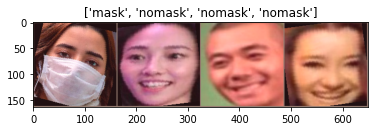

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5946, 0.4933, 0.4498])
    std = np.array([0.2210, 0.2115, 0.2100])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
               scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Epoch: {}'.format(best_epoch))
    print('Best Test Acc: {:4f}'.format(best_acc))
    scheduler.step()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Visualizing the model predictions**

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Modelo 1: Resnet18 - SGD sin momentum - Freeze
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.





In [ ]:
model_1 = torchvision.models.resnet18(pretrained=True)
for param in model_1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_1.fc.in_features
model_1.fc = nn.Linear(num_ftrs, 2)

model_1 = model_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
#optimizer_conv = optim.SGD(model_1.fc.parameters(), lr=0.001, momentum=0.5)
optimizer_conv = optim.SGD(model_1.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

**Train and evaluate**

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
%%time
model_1 = train_model(model_1, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


KeyboardInterrupt: ignored

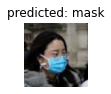

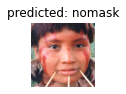

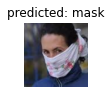

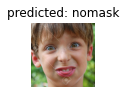

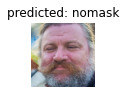

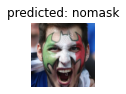

In [ ]:
visualize_model(model_1)
#plt.ioff()
plt.show()

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_1, PATH_SAVE+'model_1.model')

In [ ]:
# Load Model
loaded_model_1 = torch.load(PATH_SAVE+'model_1.model')

In [ ]:
# Iterate over data.
def fx_evaluate_model(model, dataset):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataset:
        with torch.set_grad_enabled(False):
            inputs = inputs.to(device)
            labels = labels.to(device)
       
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    value_loss = running_loss / len(dataset.dataset)
    value_acc = running_corrects.double() / len(dataset.dataset)

    print('Loss: {:4f}'.format(value_loss))
    print('Accuracy: {:4f}'.format(value_acc))

In [ ]:
fx_evaluate_model(model=loaded_model_1, dataset=dataloaders['train'])

Loss: 0.057980
Accuracy: 0.981293


In [ ]:
fx_evaluate_model(model=loaded_model_1, dataset=dataloaders['test'])

Loss: 0.129462
Accuracy: 0.957483


# Modelo 2: Resnet18 - SGD sin momentum - Fine Tuning


In [ ]:
model_2 = models.resnet18(pretrained=True)
num_ftrs = model_2.fc.in_features
model_2.fc = nn.Linear(num_ftrs, 2)

model_2 = model_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_1 = optim.SGD(model_2.fc.parameters(), lr=1e-4)
#optimizer_ft = optim.Adam(model_1_2.parameters(), lr = 0.001 , betas = (0.9 , 0.999) , 
#                          eps = 1e-08 , weight_decay = 0 , amsgrad = False )

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_1, step_size=7, gamma=0.1)

Train and evaluate

In [ ]:
%%time 
model_1_2 = train_model(model_1_2, criterion, optimizer_1, exp_lr_scheduler, num_epochs=50)

In [ ]:
visualize_model(model_1_2)

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_2, PATH_SAVE+'model_2.model')

In [ ]:
# Load Model
loaded_model_2 = torch.load(PATH_SAVE+'model_2.model')
loaded_model_2.eval()

In [ ]:
fx_evaluate_model(model=loaded_model_2, dataset=dataloaders['train'])

In [ ]:
fx_evaluate_model(model=loaded_model_2, dataset=dataloaders['test'])

# Modelo 3: Resnet18 - SGD con momentum - Freeze 

In [ ]:
model_3 = torchvision.models.resnet18(pretrained=True)
for param in model_3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_3.fc.in_features
model_3.fc = nn.Linear(num_ftrs, 2)

model_3 = model_3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_3 = optim.SGD(model_3.fc.parameters(), lr=1e-04, momentum=0.9)
#optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_3, step_size=7, gamma=0.1)

**Train and Evaluate**

In [ ]:
%%time
model_3 = train_model(model_3, criterion, optimizer_3, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3710 Acc: 0.8457
test Loss: 0.2464 Acc: 0.9303

Epoch 1/49
----------
train Loss: 0.2793 Acc: 0.8767
test Loss: 0.2739 Acc: 0.8861

Epoch 2/49
----------
train Loss: 0.2516 Acc: 0.8946
test Loss: 0.1954 Acc: 0.9303

Epoch 3/49
----------
train Loss: 0.2334 Acc: 0.9018
test Loss: 0.1861 Acc: 0.9371

Epoch 4/49
----------
train Loss: 0.2382 Acc: 0.8954
test Loss: 0.2212 Acc: 0.9082

Epoch 5/49
----------
train Loss: 0.2315 Acc: 0.8975
test Loss: 0.2210 Acc: 0.9133

Epoch 6/49
----------
train Loss: 0.2309 Acc: 0.9039
test Loss: 0.1707 Acc: 0.9371

Epoch 7/49
----------
train Loss: 0.1918 Acc: 0.9252
test Loss: 0.1947 Acc: 0.9269

Epoch 8/49
----------
train Loss: 0.2009 Acc: 0.9171
test Loss: 0.2192 Acc: 0.9133

Epoch 9/49
----------
train Loss: 0.2149 Acc: 0.9116
test Loss: 0.2344 Acc: 0.9014

Epoch 10/49
----------
train Loss: 0.1981 Acc: 0.9222
test Loss: 0.1764 Acc: 0.9388

Epoch 11/49
----------
train Loss: 0.1942 Acc: 0.9218
test Loss: 0.1846 Acc

Resultados con lr= -4

Training complete in 9m 4s

Best Epoch: 14

Best Test Acc: 0.945578

CPU times: user 4min 56s, sys: 37.1 s, total: 5min 33s

Wall time: 9min 3s

con lr-4 y momentum 0.6
Training complete in 8m 51s
Best Epoch: 20
Best Test Acc: 0.954082
CPU times: user 5min, sys: 37.8 s, total: 5min 38s
Wall time: 8min 51s

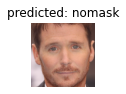

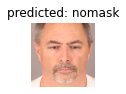

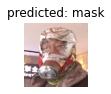

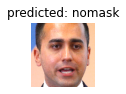

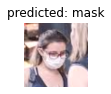

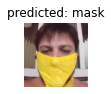

In [ ]:
visualize_model(model_3)

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_3, PATH_SAVE+'model_3.model')

In [ ]:
# Load Model
loaded_model_3 = torch.load(PATH_SAVE+'model_3.model')
loaded_model_3.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Iterate over data.
def fx_evaluate_model(model, dataset):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataset:
        with torch.set_grad_enabled(False):
            inputs = inputs.to(device)
            labels = labels.to(device)
       
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    value_loss = running_loss / len(dataset.dataset)
    value_acc = running_corrects.double() / len(dataset.dataset)

    print('Loss: {:4f}'.format(value_loss))
    print('Accuracy: {:4f}'.format(value_acc))

In [ ]:
fx_evaluate_model(model=loaded_model_3, dataset=dataloaders['train'])

Loss: 0.063780
Accuracy: 0.987245


In [ ]:
fx_evaluate_model(model=loaded_model_3, dataset=dataloaders['test'])

Loss: 0.142386
Accuracy: 0.952381


Con lr-4

Loss: 0.175859
Accuracy: 0.954082

lr-4 mom = 0.6
Loss: 0.187491
Accuracy: 0.947279

lr-4 mom = 0.5
Loss: 0.183710
Accuracy: 0.954082

lr-3 mom 0.5
Loss: 0.183710
Accuracy: 0.954082


# Modelo 4: Resnet18 - SGD con momentum - Fine Tuning

Carga el modelo Resnet18 pre-entrenado. Usa los pesos que tiene la esta red en lugar de inicializarlos al azar, y luego se entrena nuestro modelo.

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_4 = models.resnet18(pretrained=True)
num_ftrs = model_4.fc.in_features
model_4.fc = nn.Linear(num_ftrs, 2)

model_4 = model_4.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_4 = optim.SGD(model_4.fc.parameters(), lr=1e-04, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_4, step_size=7, gamma=0.1)

**Train and evaluate**



In [ ]:
%%time 
model_4 = train_model(model_4, criterion, optimizer_4, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3681 Acc: 0.8448
test Loss: 0.3355 Acc: 0.8537

Epoch 1/49
----------
train Loss: 0.2870 Acc: 0.8707
test Loss: 0.3025 Acc: 0.8622

Epoch 2/49
----------
train Loss: 0.2620 Acc: 0.8895
test Loss: 0.1823 Acc: 0.9405

Epoch 3/49
----------
train Loss: 0.2527 Acc: 0.8852
test Loss: 0.1795 Acc: 0.9286

Epoch 4/49
----------
train Loss: 0.2217 Acc: 0.9082
test Loss: 0.1786 Acc: 0.9320

Epoch 5/49
----------
train Loss: 0.2409 Acc: 0.8963
test Loss: 0.1969 Acc: 0.9201

Epoch 6/49
----------
train Loss: 0.2199 Acc: 0.9082
test Loss: 0.2062 Acc: 0.9133

Epoch 7/49
----------
train Loss: 0.2173 Acc: 0.9090
test Loss: 0.2335 Acc: 0.8963

Epoch 8/49
----------
train Loss: 0.2032 Acc: 0.9111
test Loss: 0.1548 Acc: 0.9439

Epoch 9/49
----------
train Loss: 0.2118 Acc: 0.9103
test Loss: 0.1454 Acc: 0.9473

Epoch 10/49
----------
train Loss: 0.2156 Acc: 0.9073
test Loss: 0.1556 Acc: 0.9405

Epoch 11/49
----------
train Loss: 0.2229 Acc: 0.9073
test Loss: 0.1720 Acc

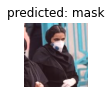

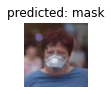

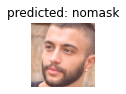

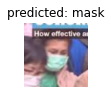

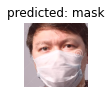

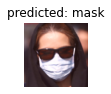

In [ ]:
visualize_model(model_4)

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_4, PATH_SAVE+'model_4.model')

In [ ]:
# Load Model
loaded_model_4 = torch.load(PATH_SAVE+'model_4.model')
loaded_model_4.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Loss: 0.096071
Accuracy: 0.974592

In [ ]:
fx_evaluate_model(model=loaded_model_4, dataset=dataloaders['train'])

Loss: 0.065455
Accuracy: 0.982568


In [ ]:
fx_evaluate_model(model=loaded_model_4, dataset=dataloaders['test'])

Loss: 0.139530
Accuracy: 0.952381


Perdida conlr-04 - Mom 0.6

Loss: 0.194552
Accuracy: 0.945578

Perdida conlr-04 - Mom 0.7

Loss: 0.176048
Accuracy: 0.947279

Perdida conlr-03 - Mom 0.7
Loss: 0.149036
Accuracy: 0.952381

Perdida con lr-4 mom 0.9 
Loss: 0.131634
Accuracy: 0.957483
...

# Modelo 5: Resnet18 - AdaGrad - Freeze 

In [ ]:
model_5 = torchvision.models.resnet18(pretrained=True)
for param in model_5.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_5.fc.in_features
model_5.fc = nn.Linear(num_ftrs, 2)

model_5 = model_5.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_5 = optim.Adagrad(model_5.fc.parameters(), lr=1e-04, lr_decay=0, 
                            weight_decay=0, initial_accumulator_value=0, eps=1e-10)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_5, step_size=7, gamma=0.1)

**Train and Evaluate**

In [ ]:
%%time
model_5 = train_model(model_5, criterion, optimizer_5, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6344 Acc: 0.6412
test Loss: 0.5928 Acc: 0.7024

Epoch 1/49
----------
train Loss: 0.6068 Acc: 0.6790
test Loss: 0.5743 Acc: 0.7211

Epoch 2/49
----------
train Loss: 0.5803 Acc: 0.7215
test Loss: 0.5683 Acc: 0.7143

Epoch 3/49
----------
train Loss: 0.5724 Acc: 0.7198
test Loss: 0.5489 Acc: 0.7466

Epoch 4/49
----------
train Loss: 0.5704 Acc: 0.7215
test Loss: 0.5292 Acc: 0.7789

Epoch 5/49
----------
train Loss: 0.5555 Acc: 0.7313
test Loss: 0.5171 Acc: 0.7908

Epoch 6/49
----------
train Loss: 0.5507 Acc: 0.7415
test Loss: 0.5106 Acc: 0.7942

Epoch 7/49
----------
train Loss: 0.5371 Acc: 0.7628
test Loss: 0.5236 Acc: 0.7772

Epoch 8/49
----------
train Loss: 0.5421 Acc: 0.7594
test Loss: 0.5002 Acc: 0.8078

Epoch 9/49
----------
train Loss: 0.5423 Acc: 0.7568
test Loss: 0.5187 Acc: 0.7857

Epoch 10/49
----------
train Loss: 0.5288 Acc: 0.7755
test Loss: 0.4873 Acc: 0.8265

Epoch 11/49
----------
train Loss: 0.5490 Acc: 0.7615
test Loss: 0.5166 Acc

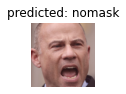

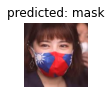

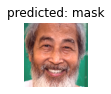

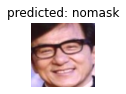

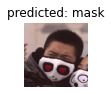

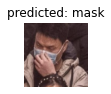

In [ ]:
visualize_model(model_5)

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_5, PATH_SAVE+'model_5.model')

In [ ]:
# Load Model
loaded_model_5 = torch.load(PATH_SAVE+'model_5.model')
loaded_model_5.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
fx_evaluate_model(model=loaded_model_5, dataset=dataloaders['train'])

Loss: 0.471909
Accuracy: 0.819728


In [ ]:
fx_evaluate_model(model=loaded_model_5, dataset=dataloaders['test'])

Loss: 0.487342
Accuracy: 0.826531


# Modelo 6: Resnet18 - AdaGrad - Fine Tuning 

In [ ]:
model_6 = models.resnet18(pretrained=True)
num_ftrs = model_6.fc.in_features
model_6.fc = nn.Linear(num_ftrs, 2)

model_6 = model_6.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_6 = optim.Adagrad(model_6.fc.parameters(), lr=1e-04, lr_decay=0, 
                            weight_decay=0, initial_accumulator_value=0, eps=1e-10)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_6, step_size=7, gamma=0.1)

**Train ad evaluate**

In [ ]:
%%time 
model_6 = train_model(model_6, criterion, optimizer_6, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.7115 Acc: 0.5068
test Loss: 0.7417 Acc: 0.5034

Epoch 1/49
----------
train Loss: 0.6614 Acc: 0.5927
test Loss: 0.7449 Acc: 0.5204

Epoch 2/49
----------
train Loss: 0.6438 Acc: 0.6173
test Loss: 0.6965 Acc: 0.5578

Epoch 3/49
----------
train Loss: 0.6315 Acc: 0.6399
test Loss: 0.6758 Acc: 0.5799

Epoch 4/49
----------
train Loss: 0.6207 Acc: 0.6514
test Loss: 0.6973 Acc: 0.5663

Epoch 5/49
----------
train Loss: 0.6052 Acc: 0.6837
test Loss: 0.6713 Acc: 0.5901

Epoch 6/49
----------
train Loss: 0.5953 Acc: 0.6935
test Loss: 0.6598 Acc: 0.6071

Epoch 7/49
----------
train Loss: 0.5851 Acc: 0.7028
test Loss: 0.6507 Acc: 0.5969

Epoch 8/49
----------
train Loss: 0.5856 Acc: 0.7143
test Loss: 0.6504 Acc: 0.6003

Epoch 9/49
----------
train Loss: 0.5835 Acc: 0.7049
test Loss: 0.6304 Acc: 0.6276

Epoch 10/49
----------
train Loss: 0.5785 Acc: 0.7160
test Loss: 0.6667 Acc: 0.5901

Epoch 11/49
----------
train Loss: 0.5847 Acc: 0.7062
test Loss: 0.6338 Acc

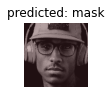

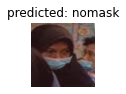

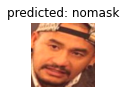

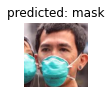

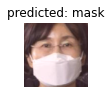

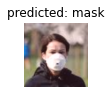

In [ ]:
visualize_model(model_6)

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_6, PATH_SAVE+'model_6.model')

In [ ]:
# Load Model
loaded_model_6 = torch.load(PATH_SAVE+'model_6.model')
loaded_model_6.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
fx_evaluate_model(model=loaded_model_6, dataset=dataloaders['train'])

Loss: 0.532899
Accuracy: 0.743197


In [ ]:
fx_evaluate_model(model=loaded_model_6, dataset=dataloaders['test'])

Loss: 0.614651
Accuracy: 0.654762


# Modelo 7: Resnet50 - sdg - Freeze 

In [ ]:
model_7 = torchvision.models.resnet50(pretrained=True)
for param in model_7.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_7.fc.in_features
model_7.fc = nn.Linear(num_ftrs, 2)

model_7 = model_7.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_7 = optim.SGD(model_7.fc.parameters(), lr=1e-04, momentum=0.9)
#optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_7, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Train and Evaluate

In [ ]:
%%time
model_7 = train_model(model_7, criterion, optimizer_7, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3850 Acc: 0.8537
test Loss: 0.2673 Acc: 0.9252

Epoch 1/49
----------
train Loss: 0.2771 Acc: 0.8903
test Loss: 0.2294 Acc: 0.9218

Epoch 2/49
----------
train Loss: 0.2373 Acc: 0.9077
test Loss: 0.2885 Acc: 0.8656

Epoch 3/49
----------
train Loss: 0.2124 Acc: 0.9158
test Loss: 0.1679 Acc: 0.9422

Epoch 4/49
----------
train Loss: 0.2094 Acc: 0.9158
test Loss: 0.1799 Acc: 0.9337

Epoch 5/49
----------
train Loss: 0.2329 Acc: 0.9048
test Loss: 0.3004 Acc: 0.8520

Epoch 6/49
----------
train Loss: 0.2186 Acc: 0.9090
test Loss: 0.1897 Acc: 0.9167

Epoch 7/49
----------
train Loss: 0.1975 Acc: 0.9171
test Loss: 0.1709 Acc: 0.9371

Epoch 8/49
----------
train Loss: 0.2054 Acc: 0.9141
test Loss: 0.2215 Acc: 0.9065

Epoch 9/49
----------
train Loss: 0.1912 Acc: 0.9230
test Loss: 0.2006 Acc: 0.9167

Epoch 10/49
----------
train Loss: 0.2006 Acc: 0.9226
test Loss: 0.1674 Acc: 0.9303

Epoch 11/49
----------
train Loss: 0.2010 Acc: 0.9179
test Loss: 0.1554 Acc

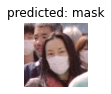

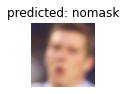

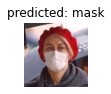

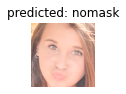

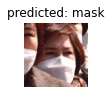

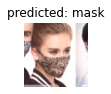

In [ ]:
visualize_model(model_7)

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_7, PATH_SAVE+'model_7.model')

In [ ]:
# Load Model
loaded_model_7 = torch.load(PATH_SAVE+'model_7.model')
loaded_model_7.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
fx_evaluate_model(model=loaded_model_7, dataset=dataloaders['train'])

Loss: 0.077408
Accuracy: 0.983844


In [ ]:
fx_evaluate_model(model=loaded_model_7, dataset=dataloaders['test'])

Loss: 0.121068
Accuracy: 0.974490


# Modelo 8: Resnet50 - SGD con momentum - Fine Tuning

https://pytorch.org/docs/stable/torchvision/models.html

https://medium.com/datos-y-ciencia/modelos-cnn-en-la-clasificaci%C3%B3n-de-im%C3%A1genes-cl%C3%A1sicas-y-modernas-d072a6718689

In [ ]:
model_8 = models.resnet50(pretrained=True)
num_ftrs = model_8.fc.in_features
model_8.fc = nn.Linear(num_ftrs, 2)

model_8 = model_8.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_8 = optim.SGD(model_8.fc.parameters(), lr=1e-04, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_8, step_size=7, gamma=0.1)

####Train and evaluate

In [ ]:
%%time
model_8 = train_model(model_8, criterion, optimizer_8, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3780 Acc: 0.8648
test Loss: 0.3167 Acc: 0.8861

Epoch 1/49
----------
train Loss: 0.2731 Acc: 0.8878
test Loss: 0.3015 Acc: 0.8673

Epoch 2/49
----------
train Loss: 0.2396 Acc: 0.9107
test Loss: 0.2463 Acc: 0.8946

Epoch 3/49
----------
train Loss: 0.2228 Acc: 0.9103
test Loss: 0.2689 Acc: 0.8724

Epoch 4/49
----------
train Loss: 0.2551 Acc: 0.8869
test Loss: 0.1786 Acc: 0.9354

Epoch 5/49
----------
train Loss: 0.2110 Acc: 0.9171
test Loss: 0.1697 Acc: 0.9490

Epoch 6/49
----------
train Loss: 0.2223 Acc: 0.9107
test Loss: 0.2596 Acc: 0.8793

Epoch 7/49
----------
train Loss: 0.2239 Acc: 0.9043
test Loss: 0.1554 Acc: 0.9439

Epoch 8/49
----------
train Loss: 0.1892 Acc: 0.9303
test Loss: 0.1390 Acc: 0.9626

Epoch 9/49
----------
train Loss: 0.2161 Acc: 0.9128
test Loss: 0.1733 Acc: 0.9371

Epoch 10/49
----------
train Loss: 0.1960 Acc: 0.9209
test Loss: 0.2116 Acc: 0.9082

Epoch 11/49
----------
train Loss: 0.2115 Acc: 0.9065
test Loss: 0.1943 Acc

In [ ]:
# Save Model
PATH_SAVE = '/content/drive/MyDrive/Colab Notebooks/Diplomado_PUCP_IA/02 - Visión_artificial/proy/MaskDectector/models/'
torch.save(model_8, PATH_SAVE+'model_8.model')

In [ ]:
# Load Model
loaded_model_8 = torch.load(PATH_SAVE+'model_8.model')
loaded_model_8.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
fx_evaluate_model(model=loaded_model_8, dataset=dataloaders['train'])

Loss: 0.084806
Accuracy: 0.979167


In [ ]:
fx_evaluate_model(model=loaded_model_8, dataset=dataloaders['test'])

Loss: 0.129060
Accuracy: 0.969388
